<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#checking for duplicates by comparing against all columns except sale details (sale type, condition and month/year of sale)

house_nosales = house.drop(house.index[-4])

house_nosales[house_nosales.duplicated()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [5]:
#remove non-residential properties
residentials = ['FV','RH','RL','RP','RM']

house = house[house['MSZoning'].isin(residentials)]

house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# A:
house.shape

(1450, 81)

In [7]:
house.dtypes[:50]

#generally the right data types based on description

Id                int64
MSSubClass        int64
MSZoning         object
LotFrontage     float64
LotArea           int64
Street           object
Alley            object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
OverallQual       int64
OverallCond       int64
YearBuilt         int64
YearRemodAdd      int64
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
MasVnrArea      float64
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinSF1        int64
BsmtFinType2     object
BsmtFinSF2        int64
BsmtUnfSF         int64
TotalBsmtSF       int64
Heating          object
HeatingQC        object
CentralAir      

In [8]:
house.describe().iloc[:,:18]

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath
count,1450.000000,1450.000000,1191.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1442.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000
mean,731.364138,56.903448,70.052897,10523.831724,6.114483,5.582069,1971.593103,1985.049655,104.404300,445.162759,46.870345,567.375862,1059.408966,1164.773103,347.394483,5.531034,1517.698621,0.427586
std,421.554345,42.265033,24.301013,10012.185355,1.372860,1.107330,30.022696,20.552319,181.486539,456.353871,161.828458,442.584978,439.207322,386.646095,437.094261,46.932966,525.154207,0.519394
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000
25%,366.250000,20.000000,59.000000,7544.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,796.000000,882.500000,0.000000,0.000000,1131.250000,0.000000
50%,731.500000,50.000000,70.000000,9496.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,384.000000,0.000000,475.000000,992.000000,1088.000000,0.000000,0.000000,1466.000000,0.000000
75%,1096.750000,70.000000,80.000000,11613.500000,7.000000,6.000000,2001.000000,2004.000000,166.750000,713.750000,0.000000,808.000000,1301.500000,1392.000000,728.000000,0.000000,1779.000000,1.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000


In [9]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

### Dealing with null values

In [10]:
house.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1361
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       681
GarageType         79
GarageYrBlt        79
GarageFinish       79
GarageCars          0
GarageArea          0
GarageQual         79
GarageCond         79
PavedDrive

#### Lot Frontage

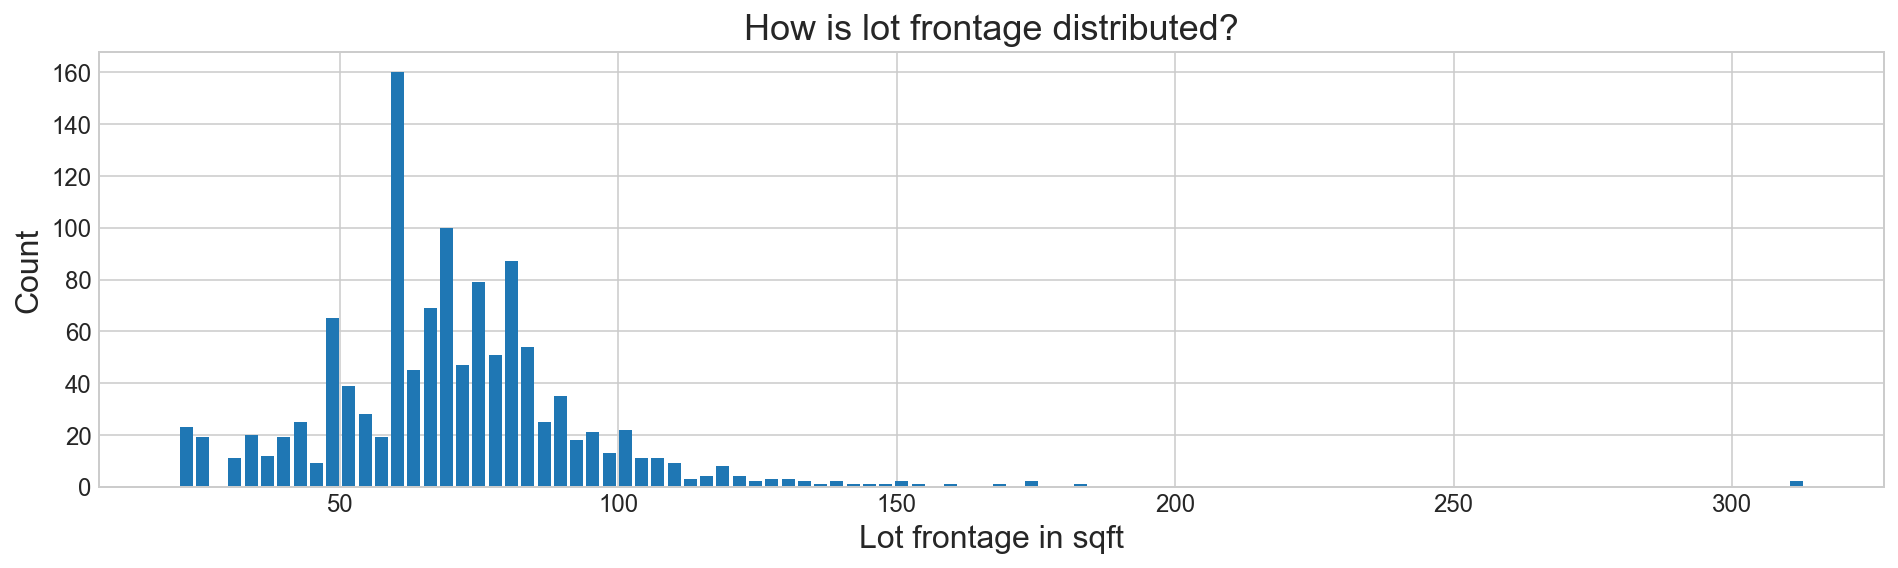

In [11]:
#lot frontage cannot be 0, so need to impute null values (too many to drop)

house['LotFrontage'].hist(figsize=(16,4),bins=100,rwidth=.8)
plt.title('How is lot frontage distributed?',fontsize=18)
plt.xlabel('Lot frontage in sqft',fontsize=16)
plt.ylabel('Count',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [13]:
#the variable appears to have high skewness with very large outliers, thus mean would not be a good imputation
#Better to use the mode of the distribution, as there are several houses falling within a small bracket of values

from statistics import mode

house['LotFrontage'].fillna(mode(house['LotFrontage']),inplace=True)

#### Alley variables

In [14]:
#impute null values for dummy-ing later

house['Alley'].fillna('None',inplace=True)

#### Masonry Veneer variables

In [15]:
#drop columns where masonry veneer details are not given
house.drop(house[house['MasVnrArea'].isnull()].index,inplace=True)

#drop columns where there is a masonry veneer type stated but the area is 0
house.drop(house[(house['MasVnrArea'] == 0) & (house['MasVnrType'] != 'None')].index,inplace=True)

#drop columns where there is masonry veneer area but no type is stated
house.drop(house[(house['MasVnrArea'] != 0) & (house['MasVnrType'] == 'None')].index,inplace=True)

In [16]:
house.shape

#15 columns removed in total. I can live with that

(1435, 81)

#### Basement variables

In [17]:
#checking to see if total basement sqft column is reliable
house['check_bsmtSF'] = house['BsmtFinSF1'] + house['BsmtFinSF2'] + house['BsmtUnfSF']

house[house['check_bsmtSF'] != house['TotalBsmtSF']]

#after confirming that the sqft tallies, must drop checking column
house.drop(columns='check_bsmtSF', inplace=True)

In [18]:
#I noticed that BsmtExposure had one extra null value than the rest
#Upon checking it, it appears that row 949 has all values except exposure
#I will impute with the most commonly occuring rating for its house style, since the documentation mentioned that certain styles tend to get a certain score (implying correlation)

house[house['BsmtExposure'].isnull()].iloc[:,30:39]

house.set_value(house['Id'] == 949,'BsmtExposure',mode(house[house['HouseStyle'] == '2Story']['BsmtExposure']))

house[house['Id'] == 949].iloc[:,30:39]

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
948,Gd,TA,No,Unf,0,Unf,0,936,936


In [19]:
#I noticed that BsmtFinType 2 has one extra null value than the rest
#as there is no indication of how it is correlated with other variables, I will drop this row

house[house['BsmtFinType2'].isnull()].iloc[:,30:39]

house.drop(house[house['Id'] == 333].index,axis=0,inplace=True)

In [20]:
house.shape

(1434, 81)

In [21]:
#the remaining null values indicate that the property does not have a basement. Impute with 'None' for dummy-ing later

house['BsmtQual'].fillna('None',inplace=True)

house['BsmtCond'].fillna('None',inplace=True)

house['BsmtExposure'].fillna('None',inplace=True)

house['BsmtFinType1'].fillna('None',inplace=True)

house['BsmtFinType2'].fillna('None',inplace=True)

#### Electrical variable

In [22]:
#not possible for house to not have electrical system, so I will drop null values
house[house['Electrical'].isnull()]

house.drop(house[house['Id'] == 1380].index,axis=0,inplace=True)

In [23]:
house.shape

(1433, 81)

#### Fireplace variables

In [24]:
#checking to make sure no odd values

house[(house['Fireplaces'] == 0) & (house['FireplaceQu'].notnull())].iloc[:,56:58]

house[(house['Fireplaces'] != 0) & (house['FireplaceQu'].isnull())].iloc[:,56:58]

#impute null values for dummy-ing later
house['FireplaceQu'].fillna('None',inplace=True)

#### Garage variables

In [25]:
#looks like all null values for this variable are because there is no garage
house[house['GarageType'].isnull()].iloc[:,58:65]

#impute with 'None' for dummy-ing for all but year built
#numerical value of years are meaningful as they denote age of the garage, which may be correlated with quality and condition. Thus it should be treated as a continuous variable
house['GarageType'].fillna('None',inplace=True)

house['GarageFinish'].fillna('None',inplace=True)

house['GarageQual'].fillna('None',inplace=True)

house['GarageCond'].fillna('None',inplace=True)

house['GarageYrBlt'].fillna(0,inplace=True)

#### Pool variables

In [26]:
#checking for values where there is a pool area but quality is not stated. Looks like everything is in order
house[(house['PoolArea'] > 0) & (house['PoolQC'].isnull())].iloc[:,71:73]

#impute null values with 0
house['PoolQC'].fillna(0,inplace=True)

#### Fence variable

In [27]:
#only one variable, to impute with 'None' for dummy-ing
house['Fence'].fillna(0,inplace=True)

#### Miscellaneous features

In [28]:
#checking for values where there is no misc feature recorded but there is a value accorded
house[(house['MiscFeature'].isnull()) & (house['MiscVal'] != 0)].iloc[:,74:76]

#checking for values where a misc feature is recorded but no value is given. Drop these rows
house[(house['MiscFeature'].notnull()) & (house['MiscVal'] == 0)].iloc[:,74:76]

house.drop(house[house['Id'] == 874].index,axis=0,inplace=True)

house.drop(house[house['Id'] == 1201].index,axis=0,inplace=True)

#remaining null values should represent houses with no misc features. Impute with 'None' for dummy-ing later
house['MiscFeature'].fillna('None',inplace=True)

house.shape

(1431, 81)

In [29]:
#final check for null value cleaning
house.isnull().sum().sum()

0

### Feature transformations

#### Log transformation

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


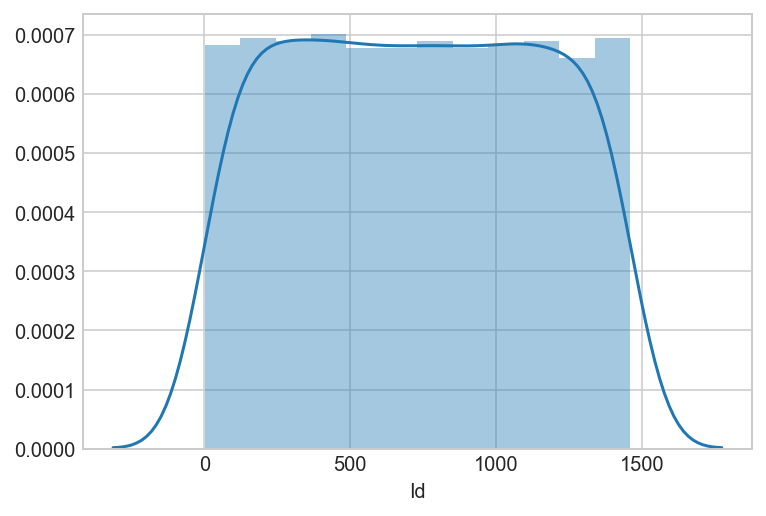

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


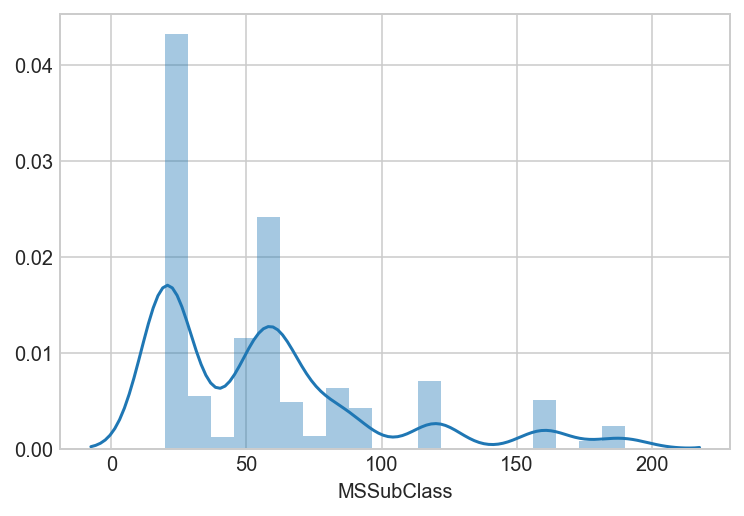

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


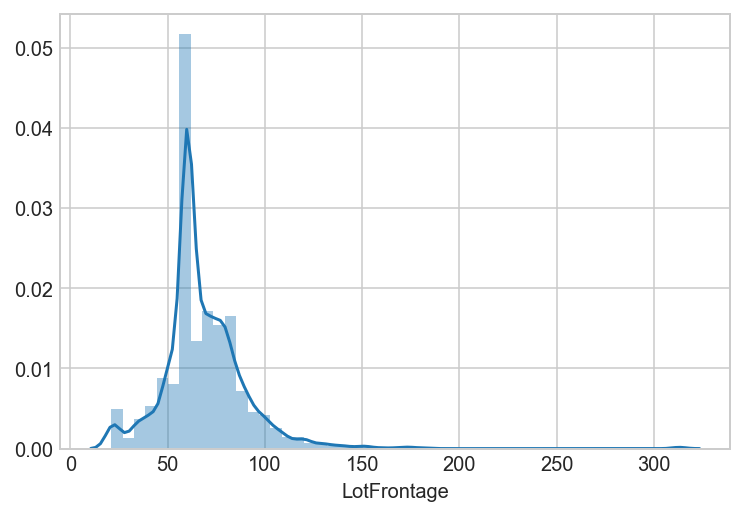

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


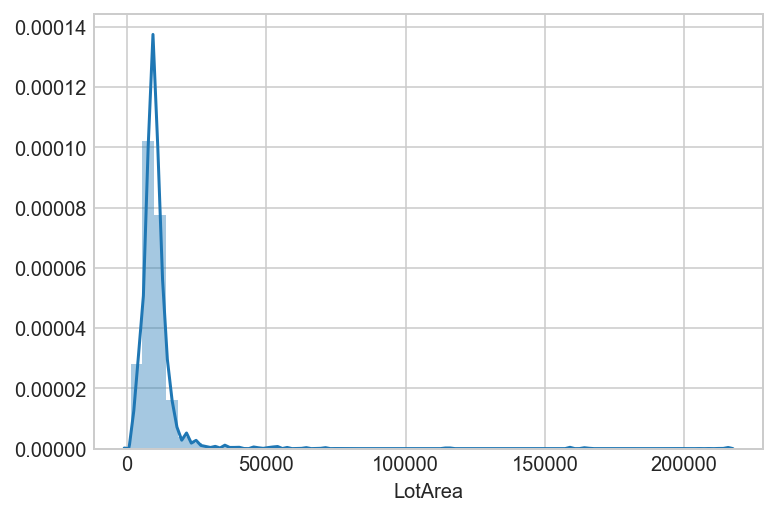

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


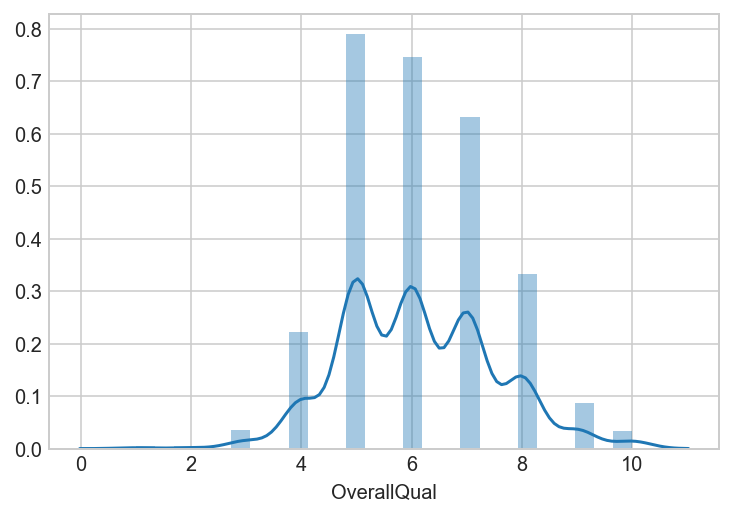

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


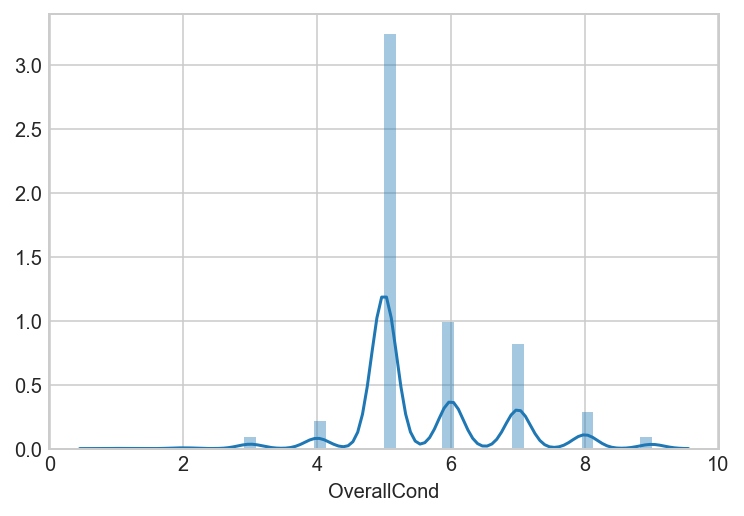

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


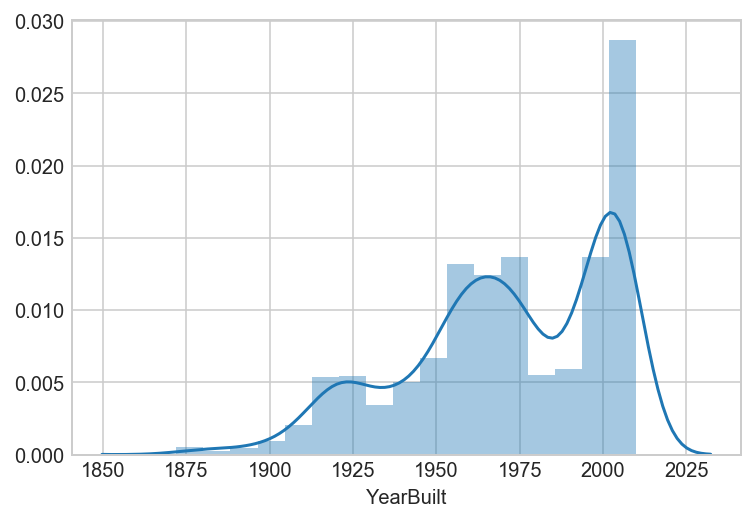

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


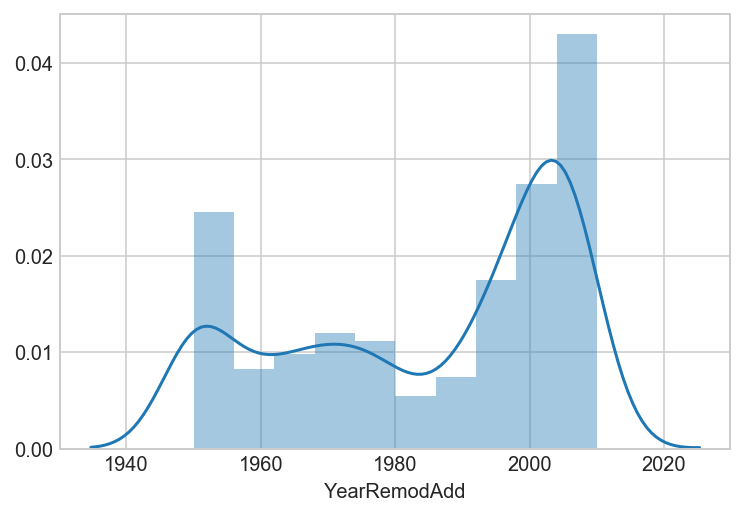

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


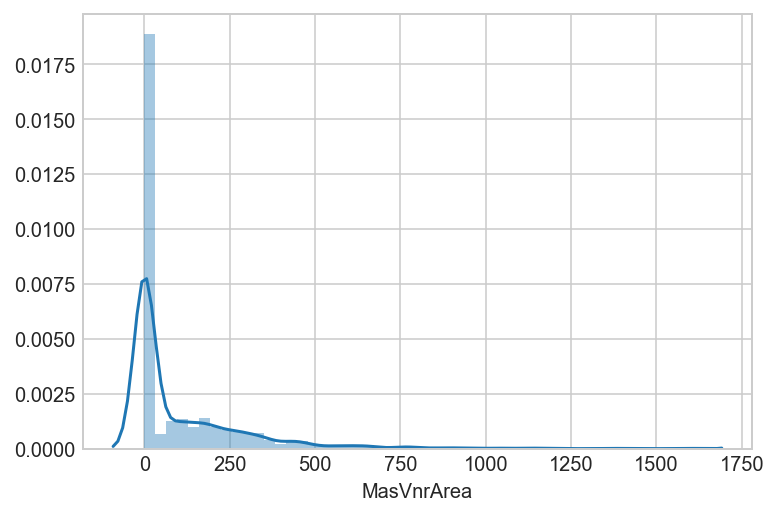

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


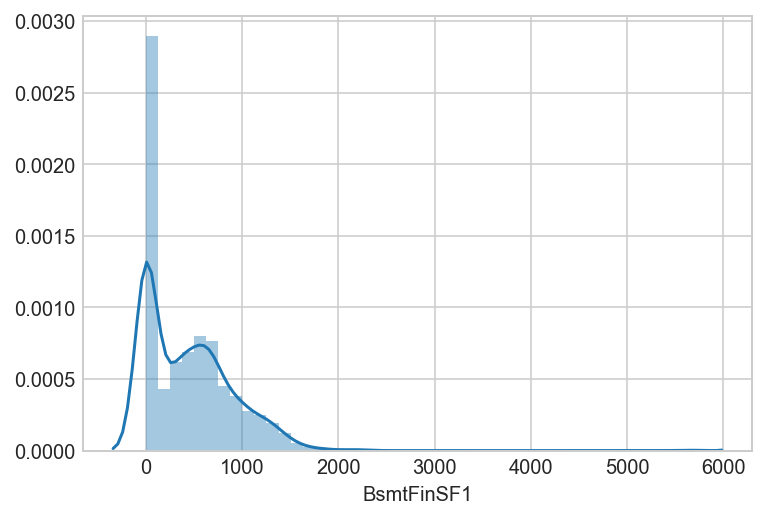

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


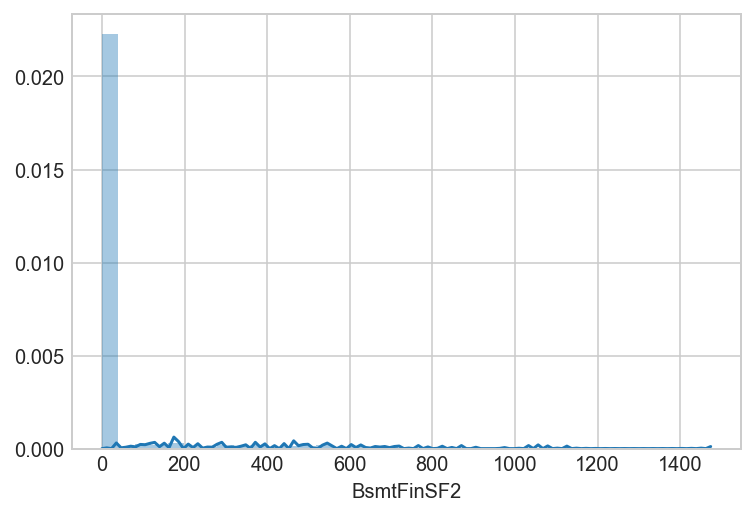

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


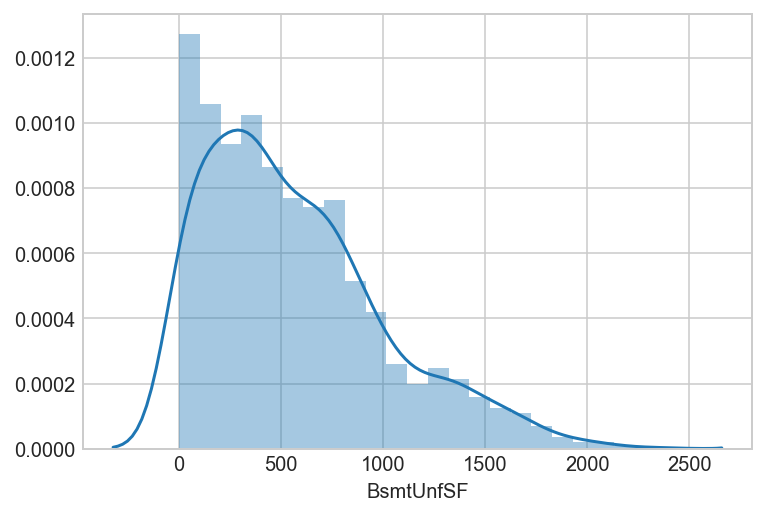

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


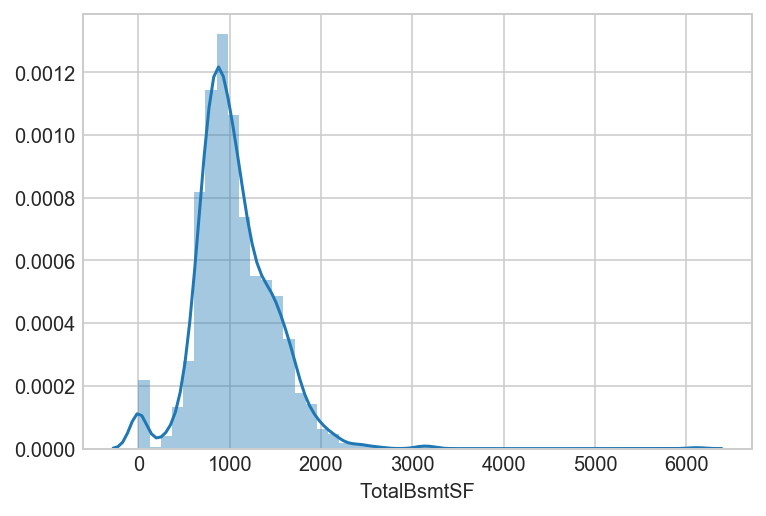

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


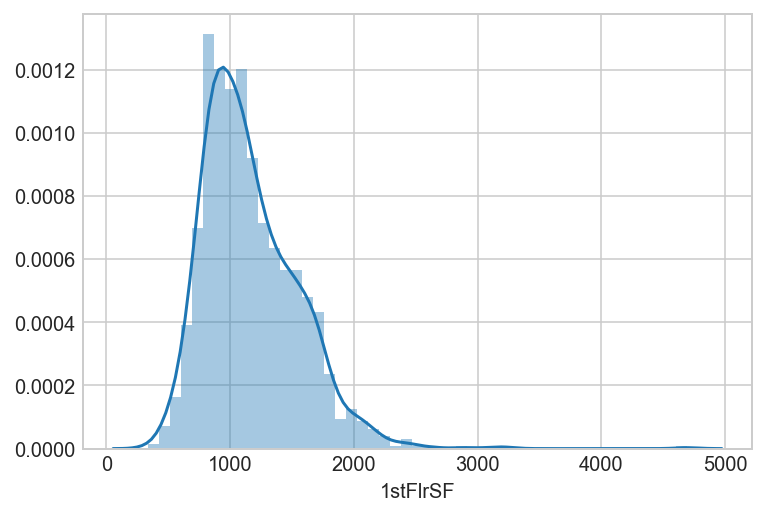

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


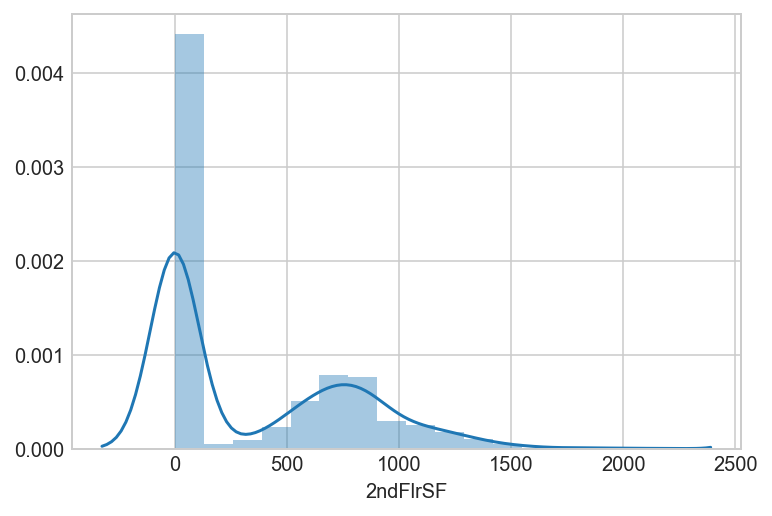

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


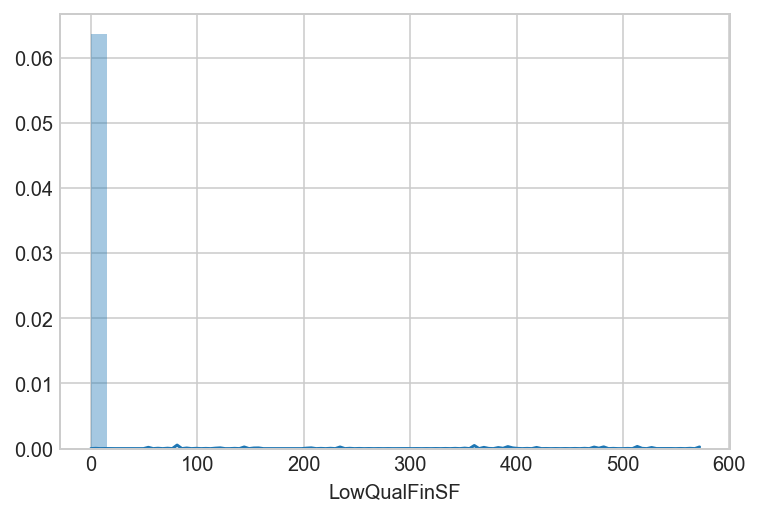

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


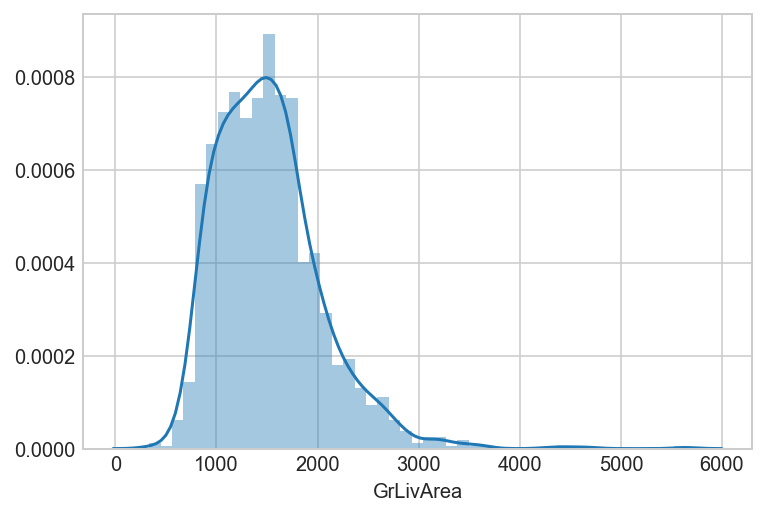

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


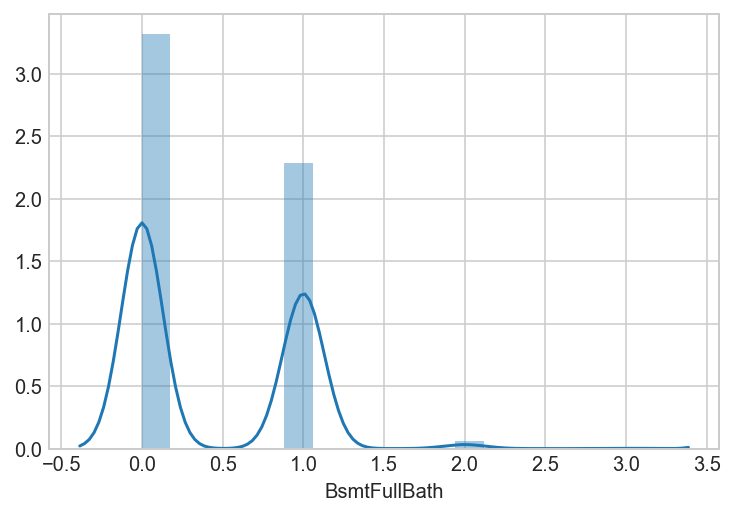

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


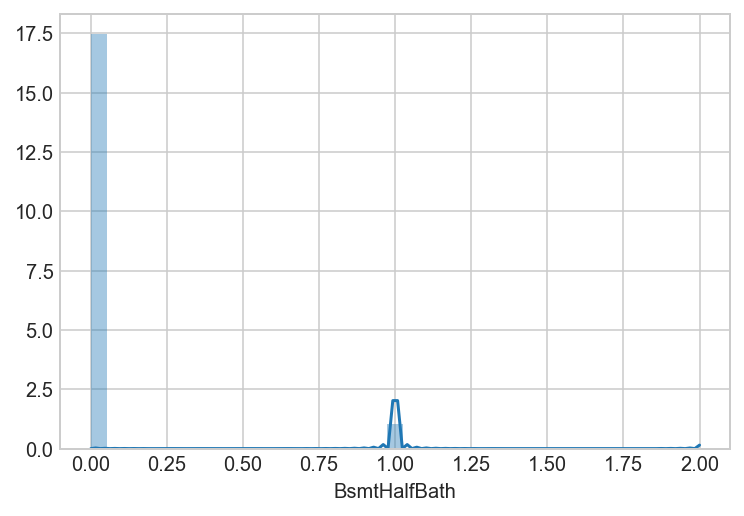

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


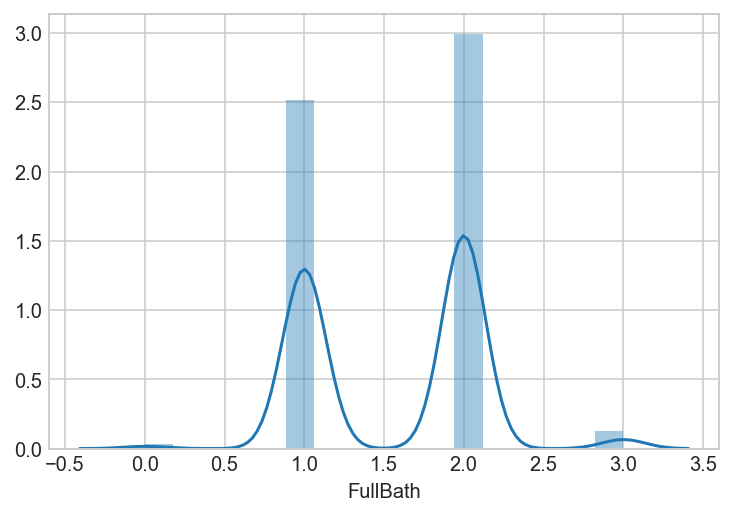

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


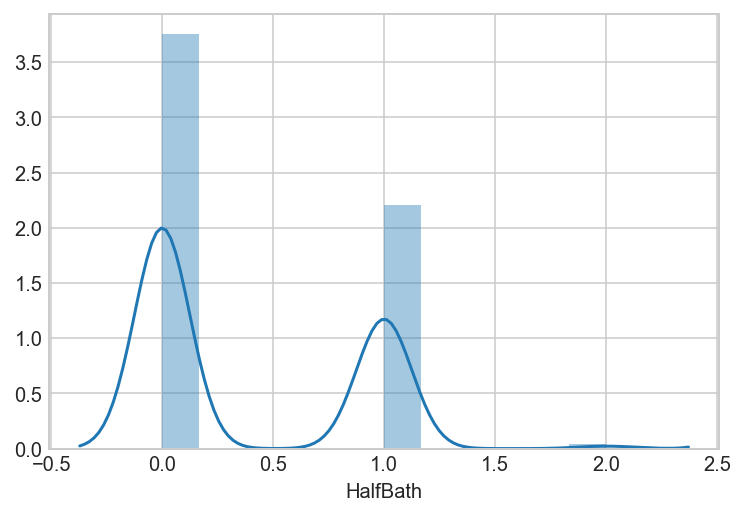

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


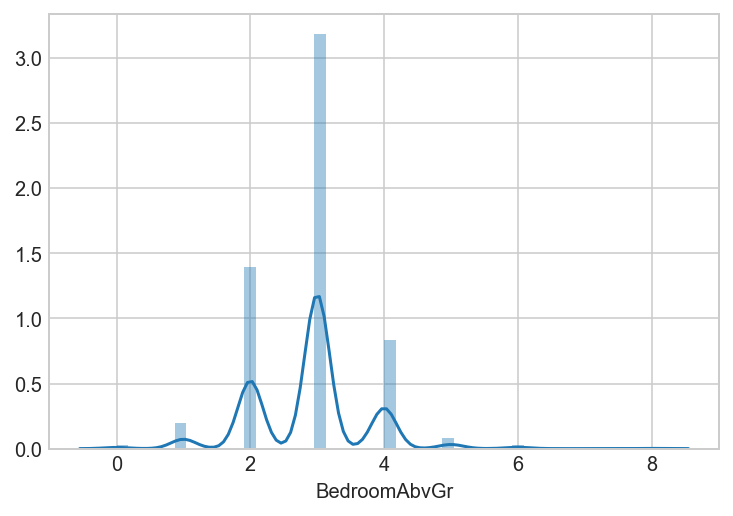

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


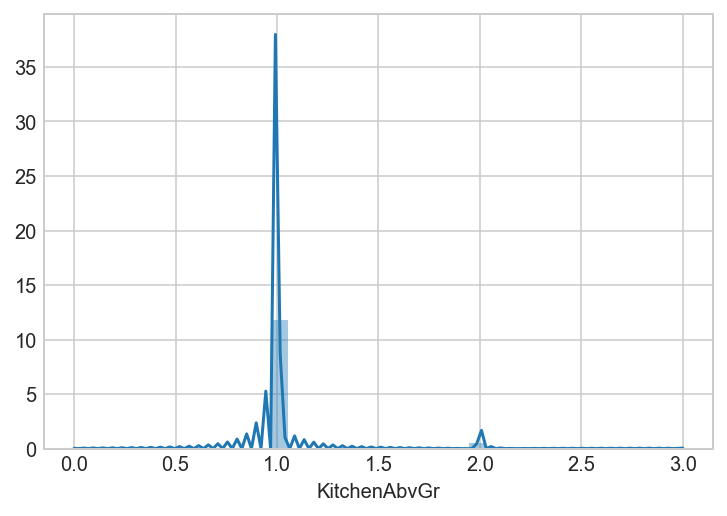

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


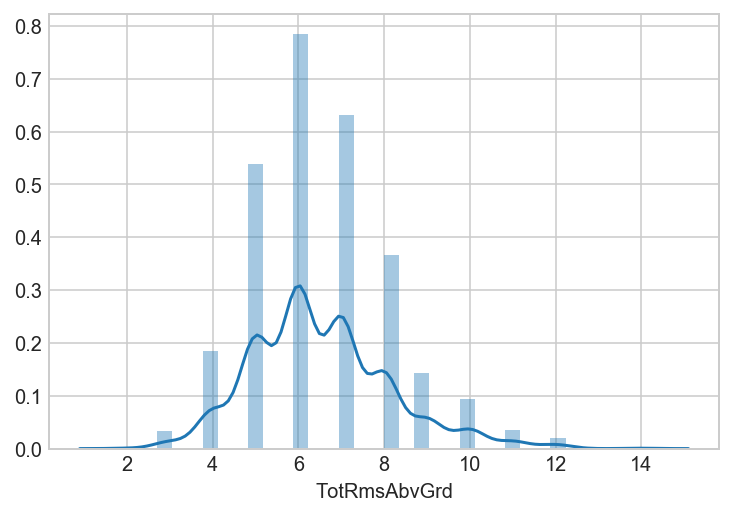

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


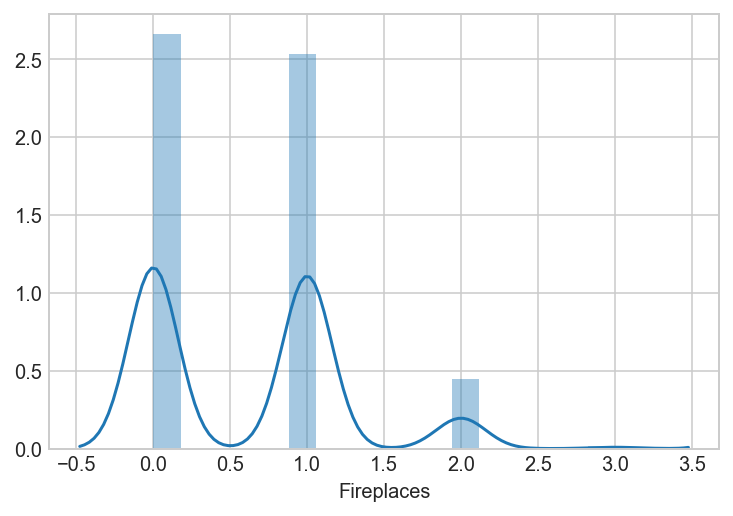

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


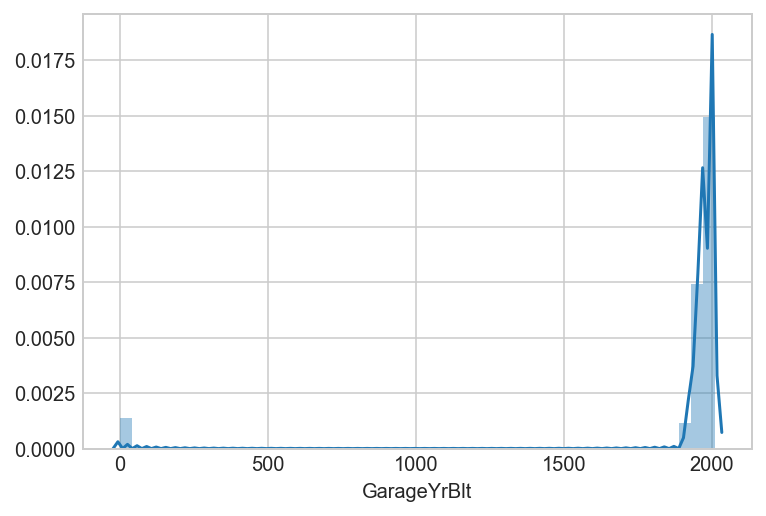

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


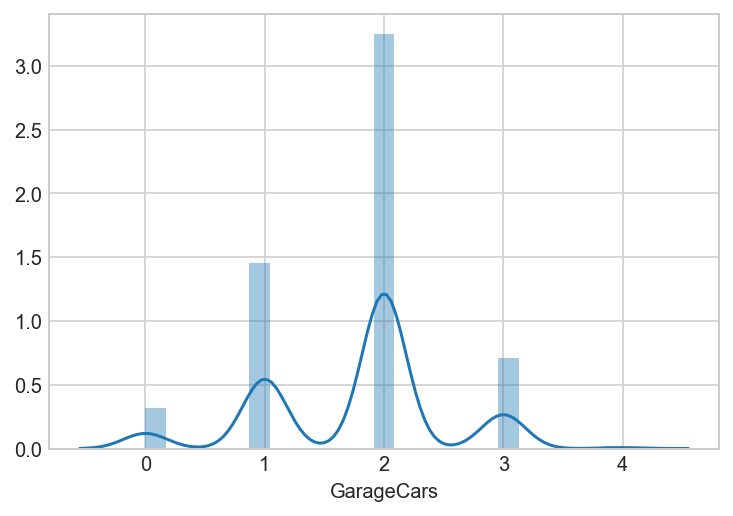

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


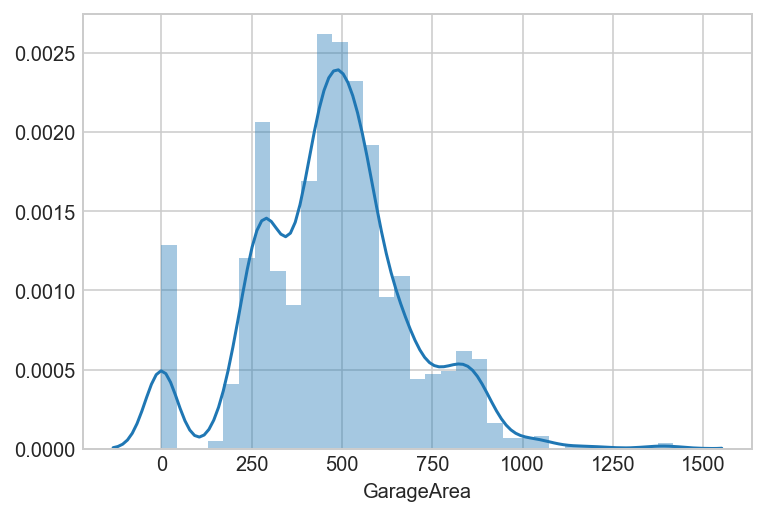

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


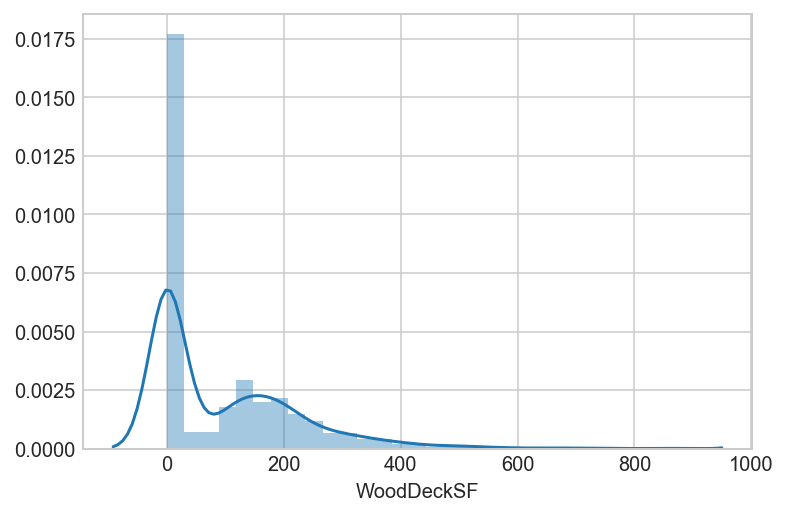

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


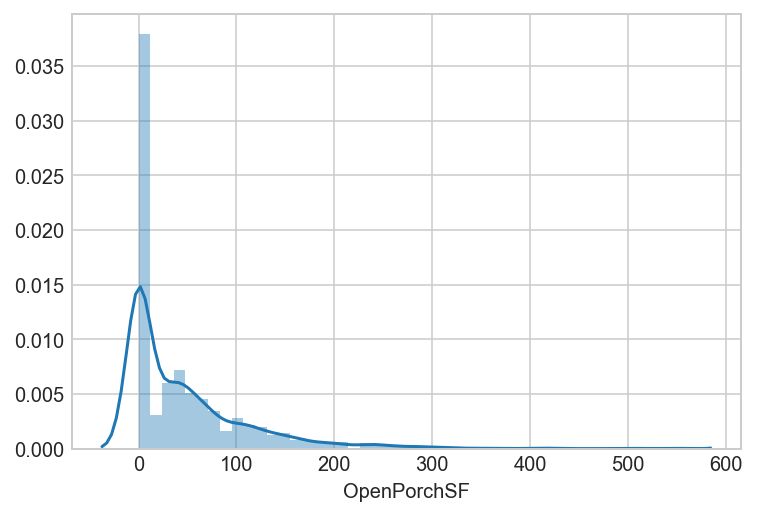

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


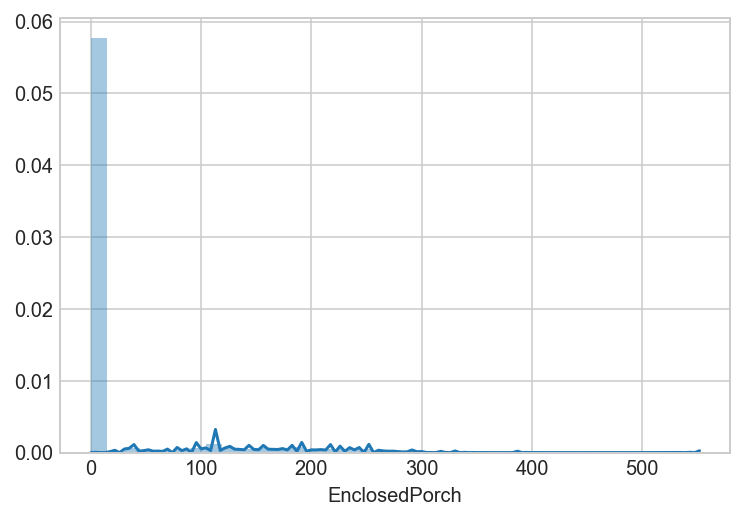

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


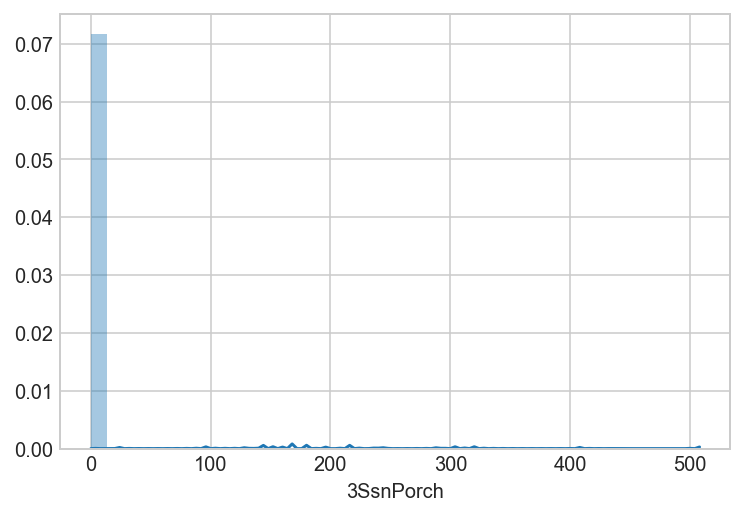

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


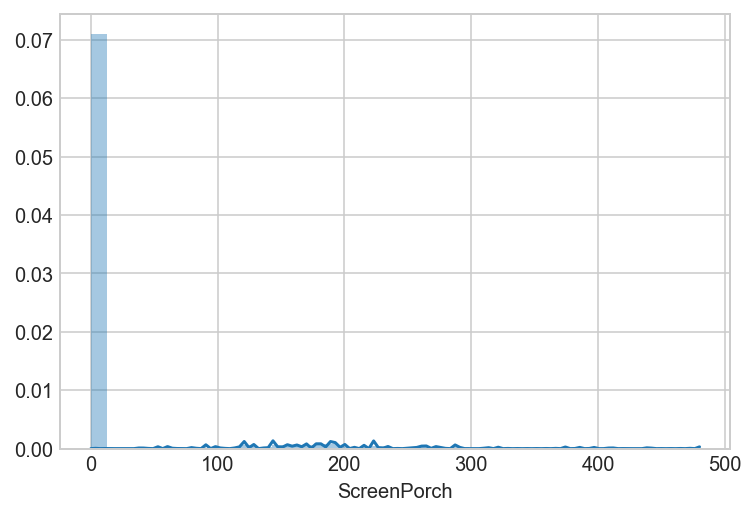

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


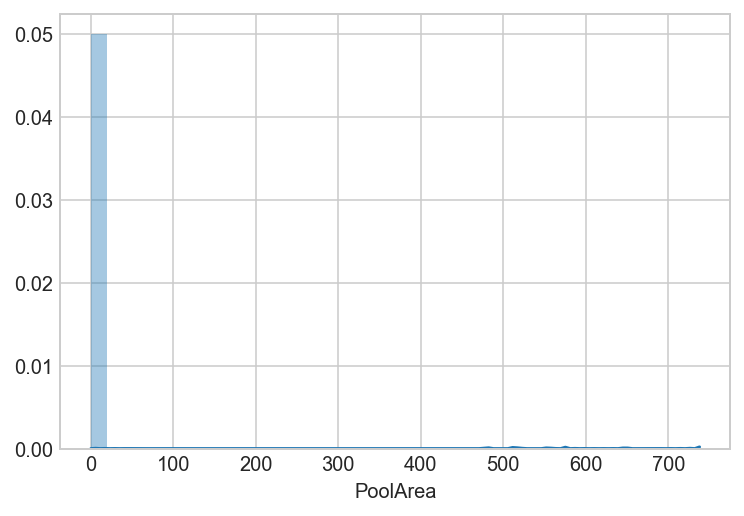

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


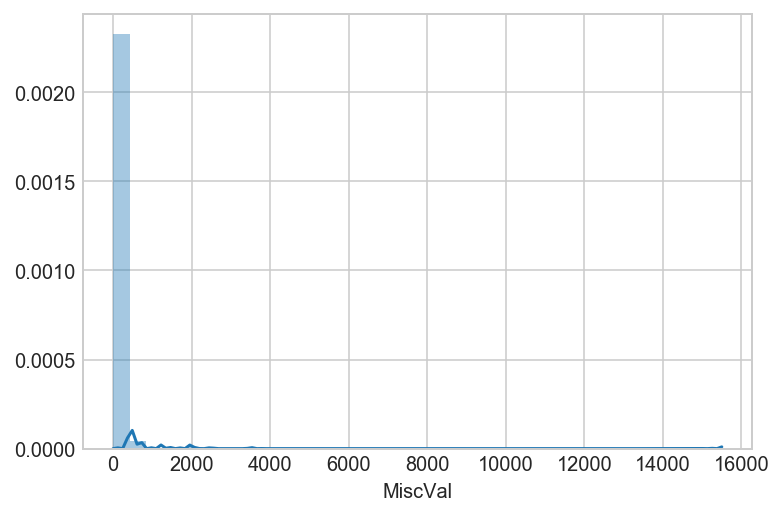

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


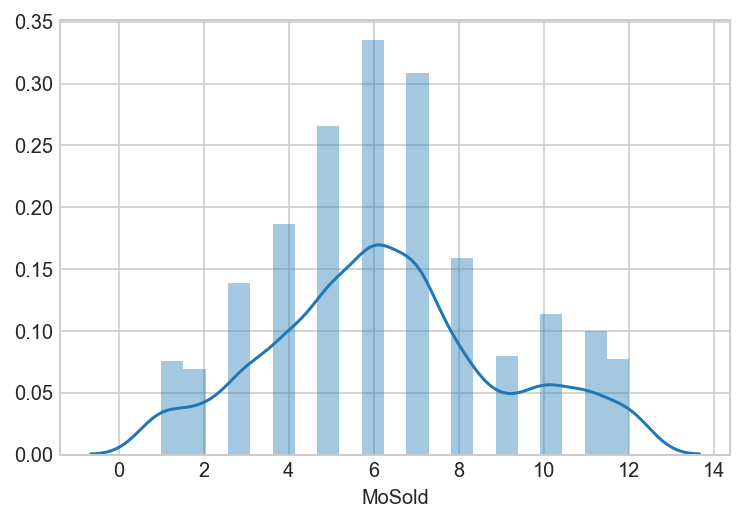

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


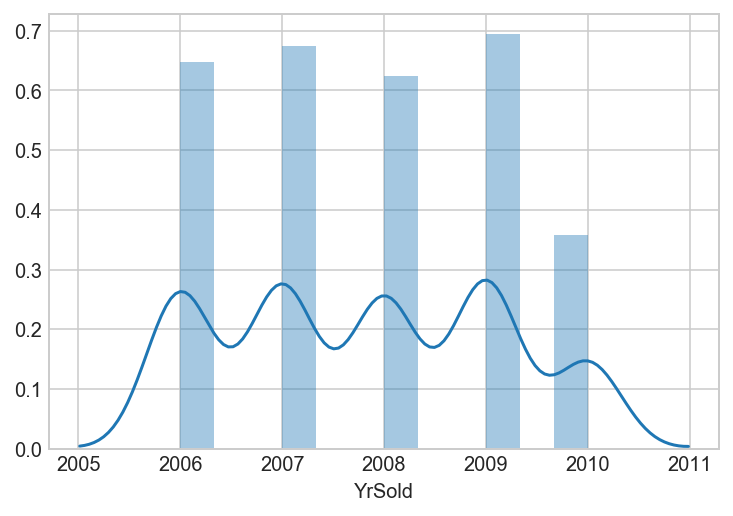

<Figure size 288x288 with 0 Axes>

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


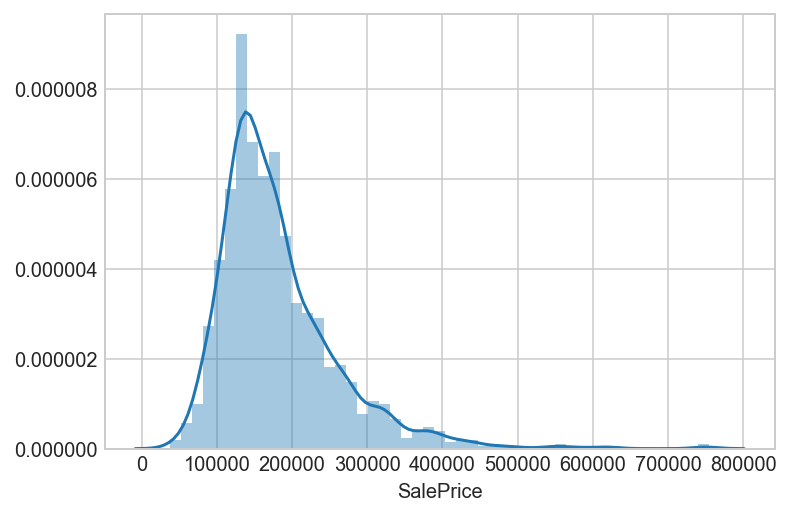

<Figure size 288x288 with 0 Axes>

SyntaxError: 'return' outside function (<ipython-input-30-e77b518cb675>, line 11)

In [30]:
# plotting distplot for all numerical variables to see distribution of values

#select numerical features for plotting
numerical_features = list(house.select_dtypes(include=['int64','float64']).columns)

#create for loop to easily create multiple graphs at once
for c in numerical_features:
    sns.distplot(house[c])
    plt.figure(figsize=(4,4))
    plt.show()
return sns.distplot(house[c])

In [31]:
#looks like there are quite a few variables skewed to the right. Need to log

tolog= ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
        'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'SalePrice']

#there are 0 values in the columns which will throw an error with log, so need to use log(1+x)
for c in tolog:
    house[c] = np.log1p(house[c])

#### Feature elimination

In [32]:
#drop id as it is not related to model
house = house.iloc[:,1:]

#drop YearBuilt as it is no longer significant once it has undergone remodelling. YearRemodAdd would include this information if the house has never been remodelled.
house.drop('YearBuilt',axis=1,inplace=True)

#drop GarageArea as it is basically the sqft of the garage presented in a different way
house.drop('GarageCars',axis=1,inplace=True)

house.shape

(1431, 78)

#### Selection of fixed and renovate-able variables

In [33]:
#I have selected land, location, overall house structure and other major structures as 'fixed' features. These are either impossible or prohibitively expensive to change, such as modifying the foundation or repositioning beams, and thus will not make financial sense for the company.

fixed_features = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearRemodAdd',
       'RoofStyle', 'Foundation', 'BsmtExposure','BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'GarageType', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']

#The remaining features, such as finishings and appliances, are relatively easier to change and improve without needing to make extensive changes to the structure of the house. These could be considered renovate-able features

renovateable_features = ['OverallQual', 'OverallCond', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF','KitchenQual',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal']

#I did not include details of the sale as these cannot be controlled by the company. They will affect the sale price, but the model was built specifically to address building features

#### Binarizing

In [34]:
#I want MSubClass to be treated as a categorical variable, so need to change its data type
house['MSSubClass'] = house['MSSubClass'].astype('str')

In [35]:
#dummy-ing categorical variables
ffeatures = house[fixed_features]

ffeatures = pd.get_dummies(ffeatures,drop_first=True)

#this is the final dataset to be used throughout part 1!
ffeatures.head()

,LotFrontage,LotArea,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,...,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None
0,4.189655,9.042040,2003,6.561031,0.0,6.753438,6.751101,7.444833,1,0,...,0,0,1,0,1,0,0,0,0,0
1,4.394449,9.169623,1976,6.886532,0.0,7.141245,0.000000,7.141245,0,1,...,1,0,0,0,1,0,0,0,0,0
2,4.234107,9.328212,2002,6.188264,0.0,6.825460,6.765039,7.488294,1,0,...,0,1,0,0,1,0,0,0,0,0
3,4.110874,9.164401,1970,5.379897,0.0,6.869014,6.629363,7.448916,1,0,...,0,0,1,0,0,0,0,0,1,0
4,4.442651,9.565284,2000,6.486161,0.0,7.044033,6.960348,7.695758,1,0,...,0,0,0,0,1,0,0,0,0,0


In [36]:
ffeatures.shape

(1431, 125)

### Train-test split (splitting manually into train and test sets)

In [37]:
y = house['SalePrice'].values
X = ffeatures

In [38]:
y_train = house[house['YrSold'] <= 2009]['SalePrice']

y_test = house[house['YrSold'] == 2010]['SalePrice']

#because ffeatures does not have YrSold (no point finding out how the year sold correlated with the price since we can't do anything with that info), need to filter from the original house dataset
X_train = ffeatures[house['YrSold'] <= 2009]

X_test = ffeatures[house['YrSold'] == 2010]

### Standardisation

In [39]:
# Initialize the StandardScaler object.
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# Use the "fit_transform" function to standardize the training set.
Xs = ss.fit_transform(X)
Xs_train = ss.fit_transform(X_train)

#Use "transform" fucntion to standardize the test set
Xs_test = ss.transform(X_test)

### Modelling (finally!)

In [40]:
from sklearn.linear_model import LinearRegression

#building basic linear regression model
lr = LinearRegression()

lr.fit(Xs_train, y_train)

# score the fit model using the train data
print(lr.score(Xs_train, y_train))

#compare with test model
print(lr.score(Xs_test, y_test))

#some dramatic overfitting is happening!

0.8924584084383788
-13081551939777.83


### Cross-validation

In [41]:
from sklearn.model_selection import cross_val_score

lr_scores = cross_val_score(lr, Xs_train, y_train, cv=20)

print(lr_scores)
print(np.mean(lr_scores))

#super negative scores, denoting that the model is performing much worse than the baseline

[ 9.09287841e-01  8.46417417e-01  8.75322190e-01  8.98489984e-01
  8.85426318e-01  8.74786181e-01 -1.54855274e+23  8.13253128e-01
 -2.58840472e+17  8.81724968e-01  8.79840348e-01 -3.62081492e+24
 -3.18024860e+24 -7.54487631e+20  8.53911679e-01  8.26030928e-01
  8.50632552e-01  3.85818587e-01  8.90226977e-01  8.27059830e-01]
-3.4783367726319875e+23


### Regularization (Ridge, Lasso, ElasticNet)

In [42]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV

#find optimal alphas value using RidgeCV
ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs_train, y_train)

print(optimal_ridge.alpha_)

255.95479226995386


In [43]:
#evaluating effectiveness of Ridge regularization
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs_train, y_train, cv=10)

print(ridge_scores)
print(np.mean(ridge_scores))

[0.90033356 0.87822626 0.87008473 0.84341195 0.84928561 0.8177959
 0.86183734 0.85611578 0.73320352 0.86581249]
0.8476107155256696


In [44]:
#finding optimal alpha values using LassoCV
optimal_lasso = LassoCV(n_alphas=50, cv=10, verbose=1)
optimal_lasso.fit(Xs_train, y_train)

print(optimal_lasso.alpha_)

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.0s finished


0.0027480498547240166


In [45]:
#evaluating effectiveness of Lasso regularization
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs_train, y_train, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

[0.90578265 0.89075805 0.87994557 0.85935387 0.85774564 0.82053694
 0.86780423 0.85136672 0.73454187 0.8629019 ]
0.8530737427444182


In [46]:
#using ElasticNetCV to find optimal combination of Ridge and Lasso in a ratio to be determined
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=20, cv=10)
optimal_enet.fit(Xs_train, y_train)

print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio_)

#ElasticNet is saying we should use Lasso completely, thus we don't need to proceed to run the Enet regularization anymore

0.002551533012193253
1.0


Looking at all the models, we therefore conclude that Lasso gives the best r2 score, and we should therefore use this to evaluate the test set. The dramatic improvement in results is probably due to high multicollinearity in several of the variables in the data, which lasso will eliminate.

### Fit test set to selected model

In [47]:
lasso.fit(Xs_test,y_test)

Lasso(alpha=0.0027480498547240166, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [48]:
#need to inverse log the sale price to interpret the final values
house['SalePrice'] = np.exp(house['SalePrice'])-1

#create a column in X_test for y-values predicted by the model, and inverse log it as well
X_test['y-pred'] = np.exp(lasso.predict(Xs_test))-1

#create a column in X_test for the residuals
X_test['residuals'] = np.exp(y_test)-1 - X_test['y-pred']

X_test.head()

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,LotFrontage,LotArea,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,...,BsmtExposure_No,BsmtExposure_None,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,y-pred,residuals
16,4.110874,9.327412,1970,6.361302,0.000000,6.912743,0.0,6.912743,1,0,...,1,0,1,0,0,0,0,0,141089.666583,7910.333417
24,4.110874,9.017605,2001,5.241747,6.505784,6.966967,0.0,6.966967,1,0,...,0,0,1,0,0,0,0,0,138453.482669,15546.517331
26,4.110874,8.881975,2000,5.459586,6.188264,6.803505,0.0,6.803505,0,1,...,0,0,0,0,0,0,1,0,133847.397937,952.602063
27,4.595120,9.348275,2008,7.105786,0.000000,7.441320,0.0,7.441320,1,0,...,1,0,1,0,0,0,0,0,294419.626979,11580.373021
33,4.262680,9.264165,1959,6.926577,0.000000,7.438972,0.0,7.438972,0,1,...,1,0,1,0,0,0,0,0,162638.650234,2861.349766


In [74]:
cross_val_score(lasso, Xs_test, y_test, cv=10)
print(lasso_scores)
print(np.mean(lasso_scores))

[ 0.13758961  0.24396066 -0.07352204  0.1335795  -0.06453742  0.4897434
 -0.08319366  0.08276746 -0.04023207 -0.08696254]
0.07391929097270143


In [75]:
#finding coefficients of each variable
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(10)

AttributeError: 'Lasso' object has no attribute 'coef_'

In [76]:
print('Number of variables removed:', np.sum((lasso.coef_ == 0)))
print('Percentage of variables removed:', 100*np.sum((lasso.coef_ == 0))/float(len(lasso.coef_)))

AttributeError: 'Lasso' object has no attribute 'coef_'

## Final model

This model has an r2 score of 0.853, meaning it calculates the price of the house with 85.3% accuracy. The model achieved this accuracy level by removing 54 variables, leaving only slightly more than half the original dataset intact.

From the last calculation, we can tell that the model has denoted the area of the garage to be the most important factor in predicting a house's price. Other important factors include the house location being in Crawford and Edwards, as well as the living room area and overall size of the first floor. Logically, this makes sense as we would expect a larger house to fetch a higher selling price, and location of a property is also often highly impactful in determining its value. Iowa is also generally a state where car ownership is commonplace due to long distances between places and a lack of public transport infrastructure, hence it is likely that the presence of a garage is attractive, if not essential, to homebuyers.

The remaining percentage is expected to be due to the renovate-able features that will be calculated in part 2.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [56]:
# A: first things first, build the dataset of renovate-able features, but only for the year 2010
rfeatures = house[renovateable_features][house['YrSold'] == 2010]

#I want overall quality and condition to be treated as categorical variables, so need to change data type
house['OverallQual'] = house['OverallQual'].astype('str')
house['OverallCond'] = house['OverallCond'].astype('str')

rfeatures = pd.get_dummies(rfeatures,drop_first=True)

#this is the final dataset to be used throughout part 2!
rfeatures.head()

,MasVnrArea,BsmtUnfSF,TotalBsmtSF,LowQualFinSF,Fireplaces,MiscVal,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,...,GarageQual_TA,GarageCond_None,GarageCond_TA,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,MiscFeature_Othr,MiscFeature_Shed
16,5.198497,6.056784,6.912743,0,1,700,0,0,1,0,...,1,0,1,0,1,0,0,0,0,1
24,0.000000,5.323010,6.966967,0,1,0,0,1,0,0,...,1,0,1,0,1,0,0,1,0,0
26,0.000000,5.198497,6.803505,0,0,0,0,1,0,0,...,1,0,1,0,1,0,0,0,0,0
27,5.303305,6.188264,7.441320,0,1,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0
33,0.000000,5.942799,7.243513,0,1,0,0,1,0,0,...,1,0,1,0,1,0,0,0,0,0


In [57]:
rfeatures.columns[:50]

Index(['MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF', 'LowQualFinSF', 'Fireplaces',
       'MiscVal', 'OverallQual_4', 'OverallQual_5', 'OverallQual_6',
       'OverallQual_7', 'OverallQual_8', 'OverallQual_9', 'OverallCond_3',
       'OverallCond_4', 'OverallCond_5', 'OverallCond_6', 'OverallCond_7',
       'OverallCond_8', 'OverallCond_9', 'RoofMatl_WdShake',
       'Exterior1st_AsphShn', 'Exterior1st_BrkFace', 'Exterior1st_CemntBd',
       'Exterior1st_HdBoard', 'Exterior1st_MetalSd', 'Exterior1st_Plywood',
       'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng',
       'Exterior1st_WdShing', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn',
       'Exterior2nd_BrkFace', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard',
       'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Plywood',
       'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng',
       'Exterior2nd_Wd Shng', 'MasVnrType_BrkFace', 'MasVnrType_None',
       'MasVnrType_Stone', 'ExterQual_Fa

In [58]:
rfeatures.shape

(171, 102)

### Train-test split (automatic splitting)

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn import metrics

y2 = X_test['residuals'].values
X2 = rfeatures

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, 
                                                    train_size=0.8, 
                                                    random_state=44)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [60]:
# Initialize the StandardScaler object.
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# Use the "fit_transform" function to standardize the training set.
Xs2 = ss.fit_transform(X2)
Xs_train2 = ss.fit_transform(X_train2)

#Use "transform" fucntion to standardize the test set
Xs_test2 = ss.transform(X_test2)

In [61]:
#building basic linear regression model
lr = LinearRegression()

lr.fit(Xs_train2, y_train2)

# score the fit model using the train data
print(lr.score(Xs_train2, y_train2))

#compare with test model
print(lr.score(Xs_test2, y_test2))

0.7505544235167803
-2.2691299382047127e+23


In [62]:
lr_scores = cross_val_score(lr, Xs_train2, y_train2, cv=20)

print(lr_scores)
print(np.mean(lr_scores))

# Perform cross-validation with a five-fold split.
kscores = cross_val_score(lr, X2, y2, cv=5)
print(kscores)
print(np.mean(kscores))

#generally very bad scores, especially so for the normal cross-validation. Most likely due to overfitting because of a lack of observations
#k-fold would do better in this regard as all parts of the data end up being used to train the model

[-4.21368733e+25 -2.99334135e+00 -2.67369944e+24 -2.24823184e+22
 -4.91616953e+22 -9.23259498e+21 -2.30365540e+00 -6.24234644e+00
 -3.64673533e+26 -9.42508406e+26 -1.23288644e+01 -2.53141613e+25
 -6.97044300e+26 -7.24761633e+21 -3.90236089e+26 -3.48178410e+00
 -2.35317857e+26 -1.72623583e+24 -1.35721499e+26 -1.51553450e+28]
-8.996392900702582e+26
[-1.50252377e+00 -2.86461730e+26 -1.93883662e+01 -1.60627024e-01
 -4.93855826e+00]
-5.729234605052607e+25


In [63]:
#find optimal alphas value using RidgeCV
ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs_train2, y_train2)

print(optimal_ridge.alpha_)

255.95479226995386


In [64]:
#evaluating effectiveness of Ridge regularization
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs_train2, y_train2, cv=10)

print(ridge_scores)
print(np.mean(ridge_scores))

[ 0.28561842  0.19692381 -0.07687074  0.58147417  0.09771712  0.24818815
 -0.15045353  0.08344169 -0.23649742  0.02777564]
0.10573173086671206


In [65]:
#finding optimal alpha values using LassoCV
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs_train2, y_train2)

print(optimal_lasso.alpha_)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

.C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
.C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................

2392.07020812326


In [66]:
#evaluating effectiveness of Lasso regularization
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs_train2, y_train2, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

[ 0.13758961  0.24396066 -0.07352204  0.1335795  -0.06453742  0.4897434
 -0.08319366  0.08276746 -0.04023207 -0.08696254]
0.07391929097270143


In [67]:
#using ElasticNetCV to find optimal combination of Ridge and Lasso in a ratio to be determined
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=20, cv=10)
optimal_enet.fit(Xs_train2, y_train2)

print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio_)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase t

23.34364339472111
0.9587500000000001


In [68]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, Xs2, y2, cv=10)

print(enet_scores)
print(np.mean(enet_scores))

#Ridge seems to be the model with the highest r2 score, so we should use this regularization penalty

[ 0.34959782 -0.10786077  0.00865186  0.25805037 -0.5384594  -0.27046495
  0.20976387 -0.01108034  0.05791638 -0.07256024]
-0.011644539467435499


In [70]:
ridge.fit(Xs_test2, y_test2)

Ridge(alpha=255.95479226995386, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [72]:
cross_val_score(ridge, Xs_test2, y_test2, cv=10)
print(ridge_scores)
print(np.mean(ridge_scores))

[ 0.28561842  0.19692381 -0.07687074  0.58147417  0.09771712  0.24818815
 -0.15045353  0.08344169 -0.23649742  0.02777564]
0.10573173086671206


The r2 value for this model is very low at 0.106. In general, this means that the model is not very efficient at accurately predicting values of data it has not been exposed to (on average, it only gets the predictions right 10.6% of the time). This is likely due to a very small sample size, as the target variable was residuals from sales of houses only in 2010.

I am confident of the data processing that has gone into this dataset, but will not recommend using the second model until further observations are collected for the residual values.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: